## 4. Modeling


In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from IPython.core.interactiveshell import InteractiveShell
from utils.model_io  import dump_pickle

warnings.filterwarnings('ignore')

habi_df = pd.read_parquet('./data/prepared/habi_feature.parquet')

In [18]:
habi_df.viability.value_counts()

viability
1    1553
0     643
Name: count, dtype: int64


### Oversampling

Nuestro dataset es imbalanceado, para la ello vamos a aplicar oversampling sobre la variable viability

In [19]:
habi_df = habi_df.sample(frac=1,random_state=5).reset_index(drop=True)

viability_df = habi_df.loc[habi_df['viability'] == 1][:643]
non_viability_df = habi_df.loc[habi_df['viability'] == 0]

normal_distributed_df = pd.concat([viability_df, non_viability_df])

# Shuffle dataframe 
habi_df = normal_distributed_df.sample(frac=1, random_state=42)

habi_df.shape

(1286, 23)

### Distribucion variable objetivo vs variables categoricas

In [20]:
binary_cols = ['terms_conditions','is_tax_return','is_selected','has_region_id','has_date_exp_token']
ohe_cols = ['type_independent_activity_id','region_id','activity','job_role','year_exp_token','year_birth','age_section','month_exp_token']
numerical_cols = ['incomes','extra_incomes','familiar_debts',] #'age'
categorical = binary_cols+ ohe_cols
target ='viability'


terms_conditions


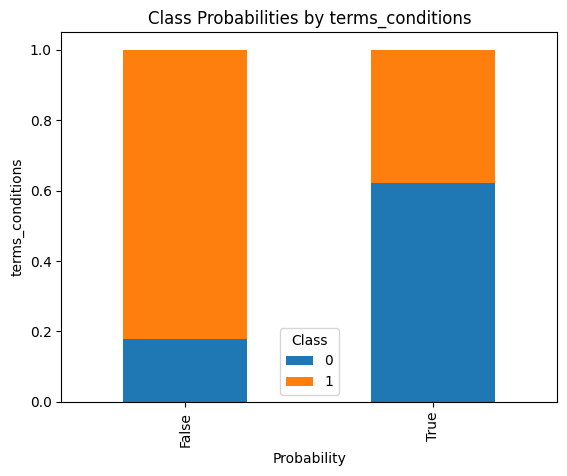

is_tax_return


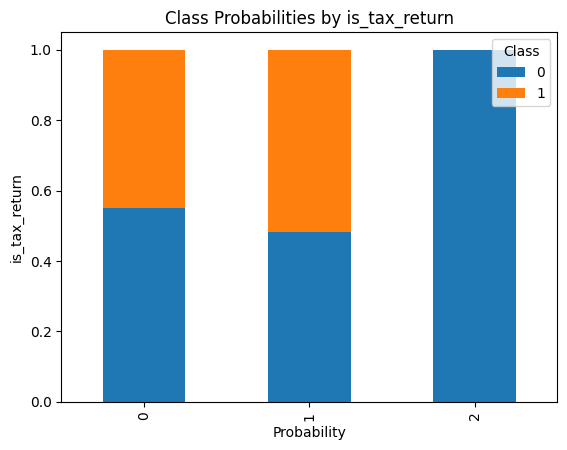

is_selected


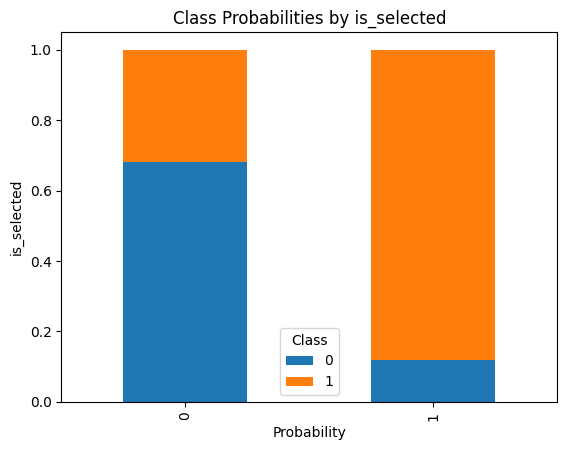

has_region_id


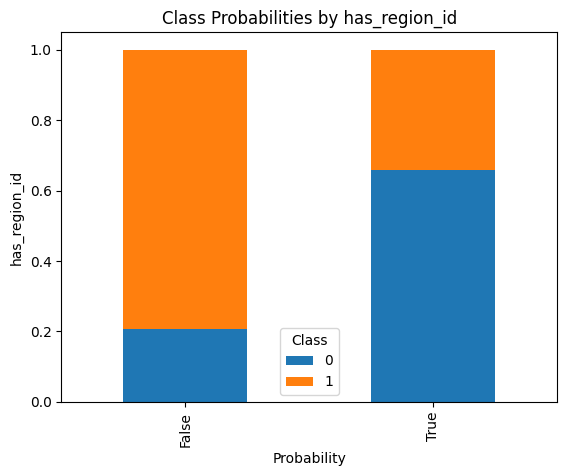

has_date_exp_token


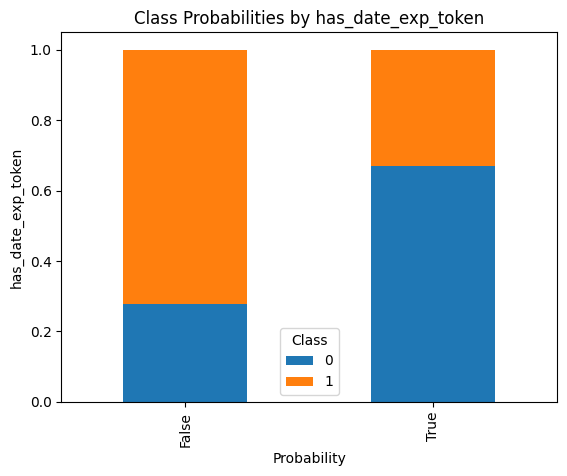

type_independent_activity_id


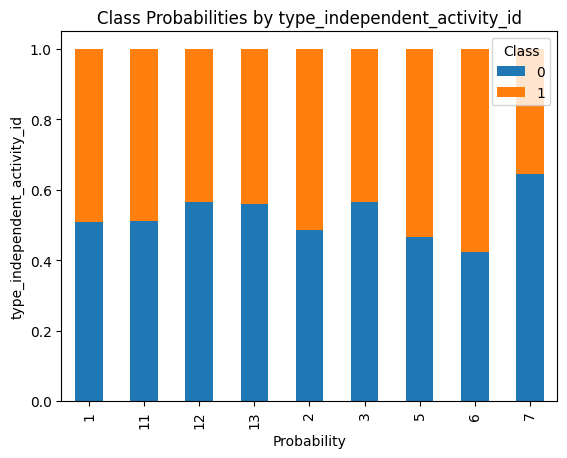

region_id


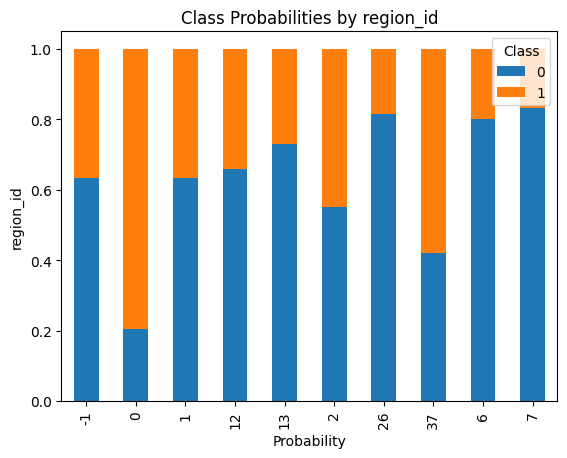

activity


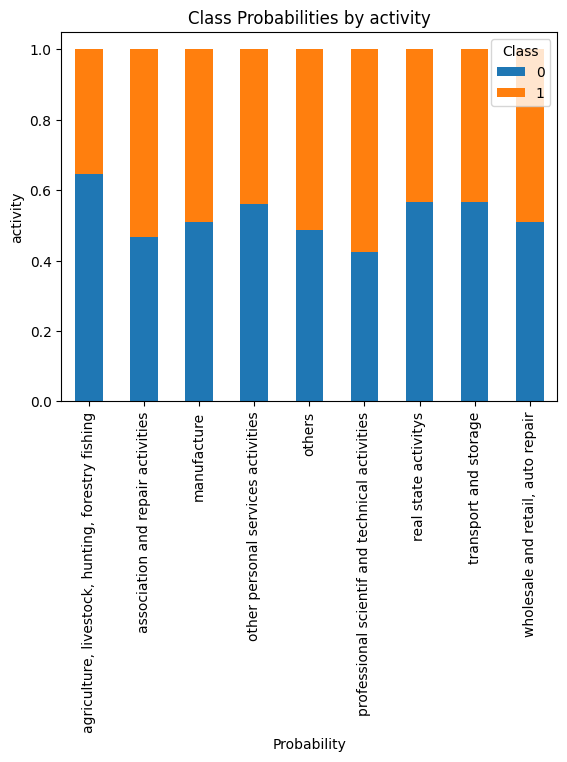

job_role


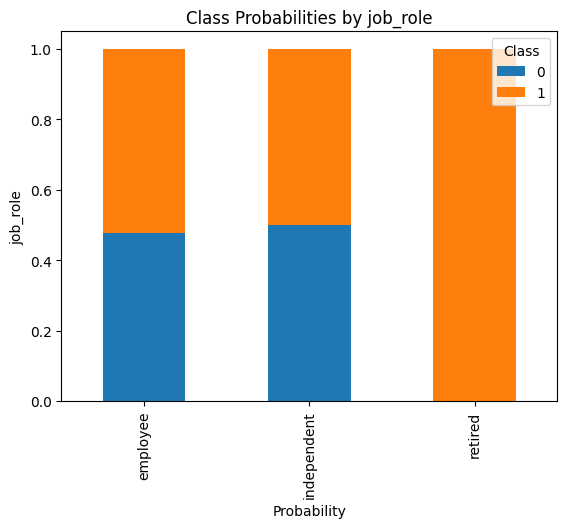

year_exp_token


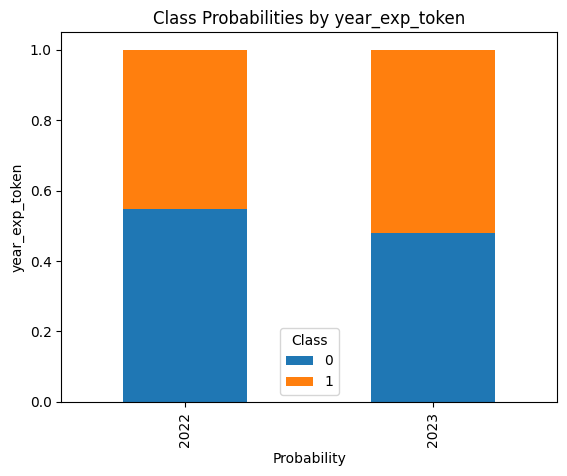

year_birth


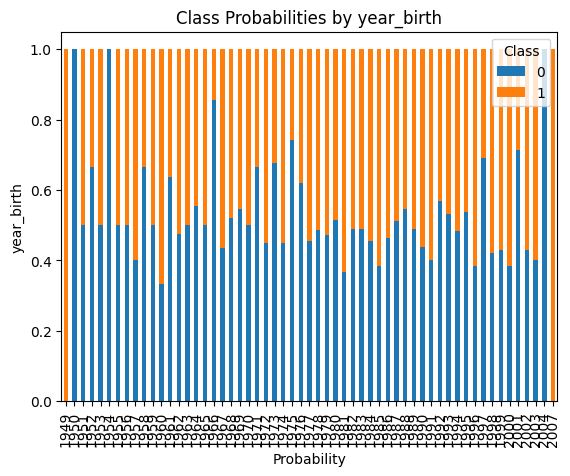

age_section


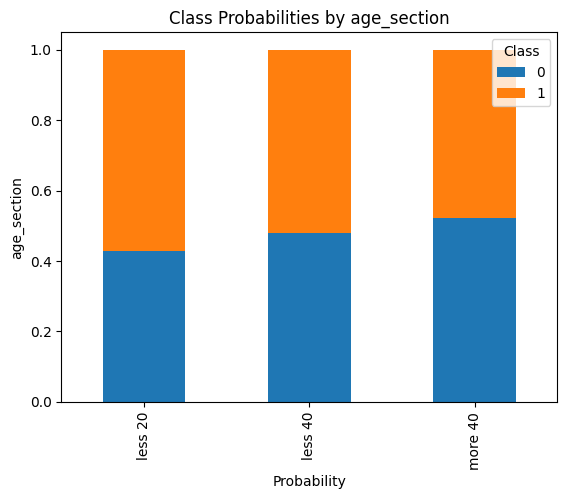

month_exp_token


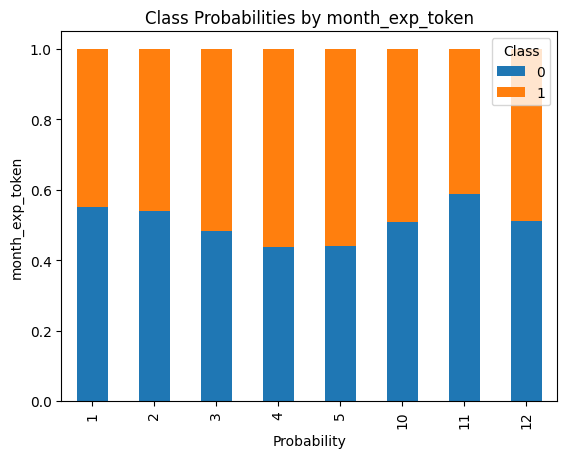

In [21]:
def proba_plot(df:pd.DataFrame,feature:str):
    # Calculate probabilities
    class_counts = df.groupby([feature, target]).size().unstack()
    class_probs = class_counts.div(class_counts.sum(axis=1), axis=0)

    # Plotting
    class_probs.plot(kind='bar', stacked=True)
    plt.xlabel('Probability')
    plt.ylabel(feature)
    plt.title(f'Class Probabilities by {feature}')
    plt.legend(title='Class')
    plt.show()
    

for c in categorical:
    print(c)
    proba_plot(habi_df,c)

# Feature importance

In [22]:
from sklearn.metrics import mutual_info_score

def mutual_info_churn_score(series):
    return mutual_info_score(series,habi_df['viability'])


mi = habi_df[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

is_selected                     0.151631
region_id                       0.109058
has_region_id                   0.097890
terms_conditions                0.083438
has_date_exp_token              0.077981
year_birth                      0.021804
month_exp_token                 0.006036
type_independent_activity_id    0.005348
activity                        0.005348
is_tax_return                   0.002901
year_exp_token                  0.001884
age_section                     0.001045
job_role                        0.000579
dtype: float64

### One-Hot-Encoding

In [23]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer


ohe_cols = ['type_independent_activity_id','is_tax_return','region_id','activity','job_role','year_exp_token','age_section']
binary_cols = ['terms_conditions','is_selected','has_extra_incomes', 'has_familiar_debts', 'has_region_id', 'has_date_exp_token']
numerical_cols = ['incomes','extra_incomes','familiar_debts']

all_cols = ohe_cols+binary_cols+numerical_cols

X, y = habi_df[all_cols].reset_index(drop=True), habi_df['viability'].reset_index(drop=True)


data_dict = X.to_dict(orient='records')

# Create an instance of DictVectorizer and fit-transform the data
vectorizer = DictVectorizer(sparse=False)
encoded_features = vectorizer.fit_transform(data_dict)

dump_pickle(vectorizer,'./artifacts/dict_vectorizer_viability.pkl')

X_encoded_df = pd.DataFrame(encoded_features, columns=vectorizer.get_feature_names_out())


In [24]:
X.to_dict(orient='records')[0]

{'type_independent_activity_id': '2',
 'is_tax_return': 1,
 'region_id': '0',
 'activity': 'others',
 'job_role': 'independent',
 'year_exp_token': '2023',
 'age_section': 'more 40',
 'terms_conditions': False,
 'is_selected': 0,
 'has_extra_incomes': 1,
 'has_familiar_debts': 0,
 'has_region_id': False,
 'has_date_exp_token': False,
 'incomes': 15.285262405144474,
 'extra_incomes': 0.0,
 'familiar_debts': 13.122365377402328}

In [25]:
X.columns

Index(['type_independent_activity_id', 'is_tax_return', 'region_id',
       'activity', 'job_role', 'year_exp_token', 'age_section',
       'terms_conditions', 'is_selected', 'has_extra_incomes',
       'has_familiar_debts', 'has_region_id', 'has_date_exp_token', 'incomes',
       'extra_incomes', 'familiar_debts'],
      dtype='object')

# Train

In [26]:
from sklearn.model_selection import train_test_split,StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(X_encoded_df, y,test_size=0.2, random_state=6, stratify=y)


In [27]:
from sklearn.metrics import f1_score
import optuna
from sklearn.metrics import confusion_matrix, classification_report

class ModelTrainer:
    def __init__(self, search_space, model, n_trials=10, n_jobs=8, cv=2):
        self.search_space = search_space
        self.model = model
        self.n_trials = n_trials
        self.n_jobs = n_jobs
        self.cv = cv
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.best_model = None
        
    def fit_data(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
    def evaluate_model(self, trial, x_train, y_train, x_val, y_val):
        params = self.search_space(trial)
    
        # Create the classifier
        classifier = self.model(**params)
        
        # Fit the classifier
        classifier.fit(x_train, y_train)
        
        # Make predictions
        preds = classifier.predict(x_val)
        
        # Calculate evaluation metrics
        score = f1_score(y_val, preds, average='weighted')
        
        return score
    
    def evaluate_cv(self, trial):        
        skf = StratifiedKFold(n_splits=self.cv)
        score_list = []
        
        for train_index, test_index in skf.split(self.X_train, self.y_train):
            x_train_fold, x_val_fold = self.X_train.iloc[train_index], self.X_train.iloc[test_index]
            y_train_fold, y_val_fold = self.y_train.iloc[train_index], self.y_train.iloc[test_index]
            score = self.evaluate_model(trial, x_train_fold, y_train_fold, x_val_fold, y_val_fold)
            score_list.append(score)
        
        return np.mean(score_list)
    
    def optimize_model(self):
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study = optuna.create_study(direction='maximize')

        # Optimize the objective function
        study.optimize(self.evaluate_cv, n_trials=self.n_trials, n_jobs=self.n_jobs)
        best_params = study.best_params
        best_score = study.best_value

        self.best_classifier = self.model(**best_params)
        self.best_classifier.fit(self.X_train, self.y_train)
        
        return best_params, best_score,self.best_classifier
    
    
class MetricPlots():
    def __init__(self, model, X_test, y_test):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = self.model.predict(self.X_test)
        self.labels = np.unique(self.y_test)
        
    def confusion_matrix(self):
        labels = [0,1]
        cm = confusion_matrix(self.y_test, self.y_pred,labels=labels)
        cm_df = pd.DataFrame(cm ,columns=labels,index=labels)
        plt.figure(figsize=(8, 8))
        plot =sns.heatmap(cm_df,cmap="PuBuGn",annot=True,fmt='g')
        plot.set(xlabel='Predicted', ylabel='Actual')
        
    def classification_report(self):
        print(classification_report(self.y_test, self.y_pred, labels=self.labels))

        


In [28]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

def SearchSpace():    
    def XGBClassifier(trial):
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'booster': 'gbtree',
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
            'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1),
            'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.6, 0.9, 0.1),
            'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10)
        }    
        return params
    
    def LogisticRegression(trial):
        params = {
            'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
            'C': trial.suggest_loguniform('C', 0.001, 100.0),
            'solver': trial.suggest_categorical('solver', [ 'liblinear', 'saga']),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
            'max_iter': trial.suggest_int('max_iter', 100, 10000),
            'random_state': 42
        }
        return params
    
    def SVC(trial):
        params = {
            'C': trial.suggest_loguniform('C', 0.001, 100.0),
            'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
            'degree': trial.suggest_int('degree', 1, 5),
            'random_state': 42,
            'probability':trial.suggest_categorical('probability', [True])
        }
        return params
    
    def MLPClassifier(trial):
        hidden_layer_sizes_choices = [
            (10,),
            (20,),
            (30,),
            (40,),
            (10, 10),
            (20, 20),
            (40, 40),
            (10, 20),
            (10,10,10)
        ]   
        
        params = {
            'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes',  hidden_layer_sizes_choices),
            'activation': trial.suggest_categorical('activation', ['logistic', 'tanh', 'relu']),
            #'learning_rate': trial.suggest_categorical('learning_rate', ['invscaling', 'adaptive']),
            'alpha':trial.suggest_loguniform('alpha', 1e-5, 1e-1),
            'random_state': 42
        }
        
        return params
    
    return dict(XGBClassifier=XGBClassifier,
                LogisticRegression=LogisticRegression,
                SVC=SVC,
                MLPClassifier=MLPClassifier)




In [29]:
model_params = SearchSpace()

# Model list for hyperparameter tuning
cv_models = [
    (xgb.XGBClassifier,model_params['XGBClassifier'],'XGBClassifier'),
    (LogisticRegression,model_params['LogisticRegression'],'LogisticRegression'),
    (SVC,model_params['SVC'],'SVC'),
    (MLPClassifier,model_params['MLPClassifier'],'MLPClassifier')
]

best_models = {}

for model, params, name in cv_models:
    model_trainer= ModelTrainer(params,model,n_trials=5,cv=3,n_jobs=-1)    
    model_trainer.fit_data(X_train,y_train,X_test,y_test)    
    best_params, best_score, best_model = model_trainer.optimize_model()
    best_models[name] = best_model
    print(f'----------MODEL: {name} ----------')
    print(f'Best score {best_score:.4f}' )
    print(f'params =  {best_params}' )
    print(f'CLASSIFICATION METRICS')
    print(f'')
    mp = MetricPlots(best_model,X_test,y_test)
    mp.classification_report()
    print(f'\n')
    



----------MODEL: XGBClassifier ----------
Best score 0.7551
params =  {'max_depth': 17, 'learning_rate': 0.0420009378991178, 'subsample': 0.9, 'colsample_bytree': 0.6, 'n_estimators': 543, 'gamma': 0.2313136252639586, 'reg_alpha': 6.9729678251459335, 'reg_lambda': 7.882704351237148}
CLASSIFICATION METRICS

              precision    recall  f1-score   support

           0       0.77      0.87      0.81       129
           1       0.85      0.74      0.79       129

    accuracy                           0.80       258
   macro avg       0.81      0.80      0.80       258
weighted avg       0.81      0.80      0.80       258



----------MODEL: LogisticRegression ----------
Best score 0.7546
params =  {'penalty': 'l1', 'C': 1.8676937097012645, 'solver': 'saga', 'fit_intercept': True, 'max_iter': 1613}
CLASSIFICATION METRICS

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       129
           1       0.86      0.78      0.82       129

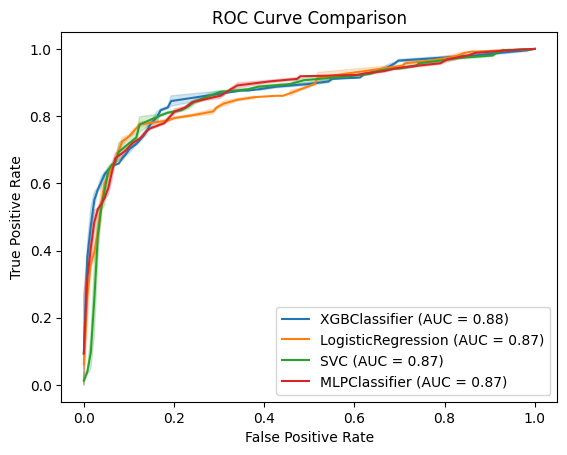

In [30]:
import seaborn as sns
from sklearn import metrics

# Create an empty figure and axis object
fig, ax = plt.subplots()

# Iterate over the models
for name, model in best_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.auc(fpr, tpr)
    sns.lineplot(x=fpr,y= tpr, ax=ax, label=f'{name} (AUC = {auc:.2f})')

# Set labels for the plot
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve Comparison')

# Display the plot
plt.show()

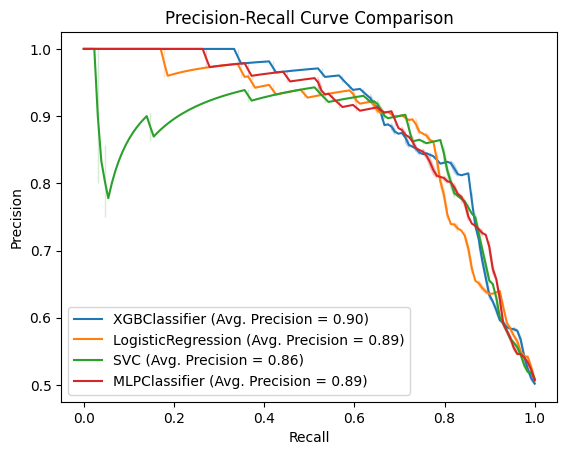

In [31]:
import seaborn as sns
from sklearn import metrics

# Create an empty figure and axis object
fig, ax = plt.subplots()

# Iterate over the models
for name, model in best_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)
    average_precision = metrics.average_precision_score(y_test, y_pred_proba)
    sns.lineplot(x=recall, y=precision, ax=ax, label=f'{name} (Avg. Precision = {average_precision:.2f})')

# Set labels for the plot
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve Comparison')
ax.legend()

# Display the plot
plt.show()

## Export models

In [32]:

for name, model in best_models.items():
    print('Saving = ',name)
    dump_pickle(model,f'./models/{name}_viability.pkl')
    

Saving =  XGBClassifier
Saving =  LogisticRegression
Saving =  SVC
Saving =  MLPClassifier
